In [18]:
import os
import glob

# 1. Load Data
def load_data(base_dir):
    texts, labels = [], []
    for sentiment in ('neg', 'pos'):
        folder = os.path.join(base_dir, sentiment)
        for filepath in glob.glob(os.path.join(folder, '*.txt')):
            filename = os.path.basename(filepath)
            try:
                score = int(filename.split('_')[1].split('.')[0])
                label = 'positive' if score > 5 else 'negative'
            except Exception:
                continue
            with open(filepath, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(label)
    return texts, labels

DATA_DIR = './aclImdb'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR  = os.path.join(DATA_DIR, 'test')

X_train, y_train = load_data(TRAIN_DIR)
X_test,  y_test  = load_data(TEST_DIR)

# Análise de Classificadores: CNN vs LSTM com Embeddings Pré-treinadas
Neste experimento, comparamos dois classificadores para análise de sentimentos em reviews IMDb usando embeddings pré-treinadas (cbow_s300.txt):
- Um classificador com camada CNN
- Um classificador com camada LSTM

In [2]:
# Importação de bibliotecas
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

In [3]:
# Função para carregar embeddings cbow_s300.txt
def load_embeddings(filepath):
    embeddings_index = {}
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            values = line.rstrip().split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_index = load_embeddings('./embeddings/cbow_s300.txt')
print(f'Total de palavras nas embeddings: {len(embeddings_index)}')

Total de palavras nas embeddings: 929606


In [19]:
# Pré-processamento dos dados (tokenização e preparação das sequências)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 20000
maxlen = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

word_index = tokenizer.word_index
print(f'Tamanho do vocabulário: {len(word_index)}')

Tamanho do vocabulário: 88582


In [20]:
# Criação da matriz de embeddings
embedding_dim = 300
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Classificador com camada CNN
cnn_model = keras.Sequential([
    layers.Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train_pad, np.array([1 if y=='positive' else 0 for y in y_train]),
                            epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.5986 - loss: 1.0582 - val_accuracy: 0.4694 - val_loss: 0.9101
Epoch 2/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - accuracy: 0.7427 - loss: 0.5153 - val_accuracy: 0.5602 - val_loss: 0.7912
Epoch 3/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.7816 - loss: 0.4625 - val_accuracy: 0.3970 - val_loss: 1.0889
Epoch 4/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 156ms/step - accuracy: 0.8198 - loss: 0.4025 - val_accuracy: 0.3482 - val_loss: 1.3036
Epoch 5/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 49s 312ms/step - accuracy: 0.8288 - loss: 0.3778 - val_accuracy: 0.5280 - val_loss: 0.9173
Epoch 6/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 48s 304ms/step - accuracy: 0.8638 - loss: 0.3169 - val_accuracy: 0.8956 - val_loss: 0.2598
Epoch 7/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 298ms/step - accuracy: 0.8738 - loss: 0.2933 - val_accuracy: 0.3542 - val_loss: 1.5128


In [26]:
# Classificador com camada LSTM
lstm_model = keras.Sequential([
    layers.Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_history = lstm_model.fit(X_train_pad, np.array([1 if y=='positive' else 0 for y in y_train]),
                              epochs=7, batch_size=128, validation_split=0.2)

Epoch 1/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 272ms/step - accuracy: 0.6341 - loss: 0.6427 - val_accuracy: 0.4554 - val_loss: 0.7879
Epoch 2/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 52s 334ms/step - accuracy: 0.7503 - loss: 0.5143 - val_accuracy: 0.8834 - val_loss: 0.3460
Epoch 3/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 51s 323ms/step - accuracy: 0.7905 - loss: 0.4432 - val_accuracy: 0.8298 - val_loss: 0.4192
Epoch 4/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - accuracy: 0.8385 - loss: 0.3735 - val_accuracy: 0.6266 - val_loss: 0.7896
Epoch 5/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 54s 343ms/step - accuracy: 0.8630 - loss: 0.3255 - val_accuracy: 0.5832 - val_loss: 0.8733
Epoch 6/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 297ms/step - accuracy: 0.8740 - loss: 0.2950 - val_accuracy: 0.7482 - val_loss: 0.5893
Epoch 7/7
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - accuracy: 0.9041 - loss: 0.2430 - val_accuracy: 0.7066 - val_loss: 0.7397


In [27]:
# Avaliação dos modelos
cnn_eval = cnn_model.evaluate(X_test_pad, np.array([1 if y=='positive' else 0 for y in y_test]))
lstm_eval = lstm_model.evaluate(X_test_pad, np.array([1 if y=='positive' else 0 for y in y_test]))
print(f'CNN - Loss: {cnn_eval[0]:.4f}, Accuracy: {cnn_eval[1]:.4f}')
print(f'LSTM - Loss: {lstm_eval[0]:.4f}, Accuracy: {lstm_eval[1]:.4f}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8650 - loss: 0.3433
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.8583 - loss: 0.3464
CNN - Loss: 0.8326, Accuracy: 0.6554
LSTM - Loss: 0.4903, Accuracy: 0.7998


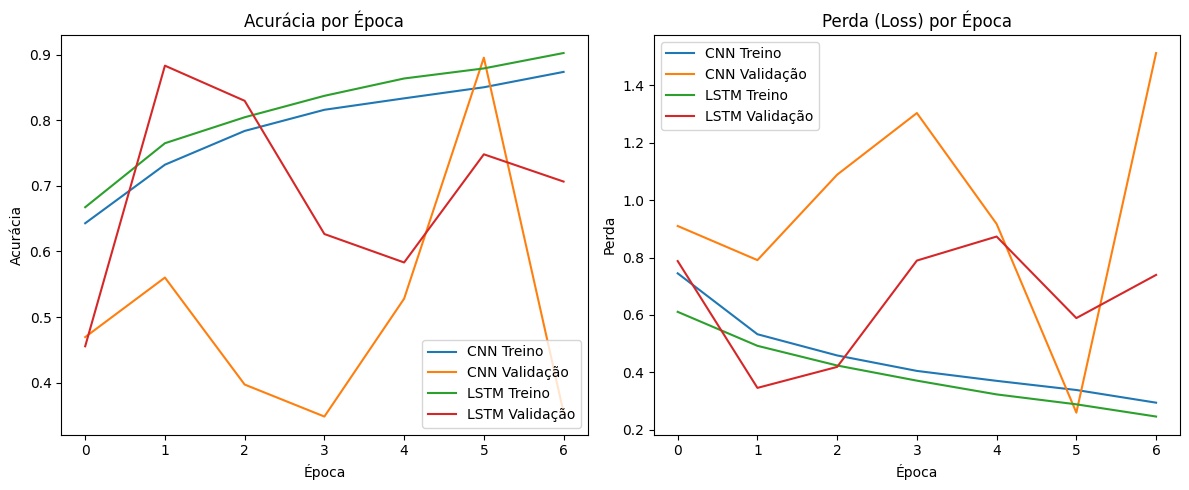

In [28]:
# Gráficos de comparação entre acurácia e perda dos modelos
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(cnn_history.history['accuracy'], label='CNN Treino')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validação')
plt.plot(lstm_history.history['accuracy'], label='LSTM Treino')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1,2,2)
plt.plot(cnn_history.history['loss'], label='CNN Treino')
plt.plot(cnn_history.history['val_loss'], label='CNN Validação')
plt.plot(lstm_history.history['loss'], label='LSTM Treino')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validação')
plt.title('Perda (Loss) por Época')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()